## Evaluation Metrics for Classification Models

### 1. Classification model

Let's begin by repeating the preprocessing and modeling we did in notebook 2:

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

Loading the data:

In [2]:
df = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

Preprocessing:

In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for column in categorical_columns:
    df[column] = df[column].str.lower().str.replace(' ', '_')

df['totalcharges'] = pd.to_numeric(df['totalcharges'], errors='coerce')
df['totalcharges'] = df['totalcharges'].fillna(0)

df['churn'] = (df['churn'] == 'yes').astype(int)

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['churn'].values
y_val = df_val['churn'].values
y_test = df_test['churn'].values

#del df_train['churn']
#del df_val['churn']
#del df_test['churn']

In [5]:
numerical_features = ['tenure', 'monthlycharges', 'totalcharges']

categorical_features = ['gender', 'seniorcitizen', 'partner', 'dependents',
    'phoneservice', 'multiplelines', 'internetservice', 'onlinesecurity','onlinebackup',
    'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'contract',
    'paperlessbilling', 'paymentmethod']

Modeling:

In [6]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical_features + numerical_features].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [7]:
val_dict = df_val[categorical_features + numerical_features].to_dict(orient='records')
X_val = dv.fit_transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = y_pred >= 0.5
(y_val == churn_decision).mean()

0.8034066713981547

### 2. Accuracy and dummy model

Now we are going to answer the question: is 80% score good enough for this model?

#### 2.1 Evaluate the model on different threshols

Due to the fact that we assigned a threshold (`0.5`) to decide if our prediction is `1` or `0`, we obtainded a certain number of churning customers, but this can change if we choose a different treshold. Let's inspect that: 

In [11]:
thresholds = np.linspace(0, 1, 21)
scores = []

for threshold in thresholds:
    churn_decision = y_pred >= threshold
    score = (y_val == churn_decision).mean()
    print('%.2f %.3f' % (threshold, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


Let's plot these results:

Text(0, 0.5, 'score')

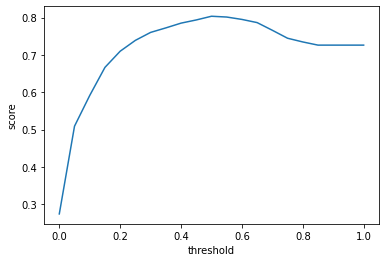

In [13]:
plt.plot(thresholds, scores)
plt.xlabel('threshold')
plt.ylabel('score')

This curve show us that there is a maximum score for a given treshold value, which actually optimizes the model's performance for a particular traing dataset.

We have a specific funcion in `Scikit-Learn` to this process:

In [14]:
from sklearn.metrics import accuracy_score

In [15]:
churn_decision = y_pred >= 0.5
accuracy_score(y_val, churn_decision)

0.8034066713981547

Let's repeat changeing our threshold value:

In [18]:
thresholds = np.linspace(0, 1, 21)
scores = []

for threshold in thresholds:
    churn_decision = y_pred >= threshold
    score = accuracy_score(y_val, churn_decision)
    print('%.2f %.3f' % (threshold, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


#### 2.2 Checking the accuracy for dummy baselines

There are a couple of situations that may have our attention. One of them is when we set our threshold to `1`, which means that we're saying that none of the custormes will churn.

If we say that, we'll obtain an accuracy of `72.6%`. This means that __accuracy__ is not a good performance's measure for our classification model. 

### 3. Confusion table

#### 3.1 Different type of errors and correct decisions

#### 3.2 Arranging errors in a table

### 4. Precision and Recall

### 5. ROC Curves

#### 5.1 TPR and FRP

#### 5.2 Random model

#### 5.3 Ideal model

### 6. ROC AUC

#### 6.1 Area under the ROC curve

#### 6.2 Interpretation of AUC

### 7. Cross-Validation

#### 7.1 Evaluating the same model on different subsets of data

#### 7.2 Getting the average prediction and the spread within prediction